<a href="https://colab.research.google.com/github/Riddick4-droid/ComputerVision-TensorFlow/blob/main/Generative_Adversarial_Networks_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing Generative Adversarial Networks in TensorFlow

The field of computer vision has come a long way. From models that can correctly classifier an image to models that can detect objects in the minutest form-thus object detection and pixel level classification and localization for semantic segmentation. With base models stemming from convolutional neural networks advancing to transformers and shifted windows which can be used to perform a series of tasks. Not to forget the SOTA Yolo v5 and incoming Yolov26 models which perform well on real-time object detection with a more sophisticated architecture. GANs on the other hand although a computer vision branch specializes or finds itself being bred in the generative space. It has the ability to `generate` images based on what it was trained on. common in machine learning, `if you want your model to be more versatile-give it more versatile data`. In this notebook, I walk through how to implement this deep network on the simplest of training data `MNIST Handwritten digits` dataset.

For more information on how GANs work into details, consider reading the paper on it at : https://arxiv.org/abs/1406.2661 . The paper offers insight into the architecture and how it differs and similarizes to normal computer vision models as well as it performance

In [ ]:
##install necessary dependencies
try:
    import tensorflow as tf
except ModuleNotFoundError:
    print('[INFO] module not found...installing...')
    !pip install -qU tensorflow
    import tensorflow as tf

In [ ]:
##load the dataset for training
from tensorflow.keras.datasets import cifar10, mnist

#get mnist
mnist_data = mnist.load_data()

#get cifar-10
cifar_data = cifar10.load_data()

In [ ]:
# Explore the MNIST data
print("MNIST data shapes:")
print(f"  Training images shape: {mnist_data[0][0].shape}")
print(f"  Training labels shape: {mnist_data[0][1].shape}")
print(f"  Test images shape: {mnist_data[1][0].shape}")
print(f"  Test labels shape: {mnist_data[1][1].shape}")
print(f"  MNIST training images dtype: {mnist_data[0][0].dtype}")

# Explore the CIFAR-10 data
print("\nCIFAR-10 data shapes:")
print(f"  Training images shape: {cifar_data[0][0].shape}")
print(f"  Training labels shape: {cifar_data[0][1].shape}")
print(f"  Test images shape: {cifar_data[1][0].shape}")
print(f"  Test labels shape: {cifar_data[1][1].shape}")
print(f"  CIFAR-10 training images dtype: {cifar_data[0][0].dtype}")

# TRAINING MODEL ON MNINST DATA

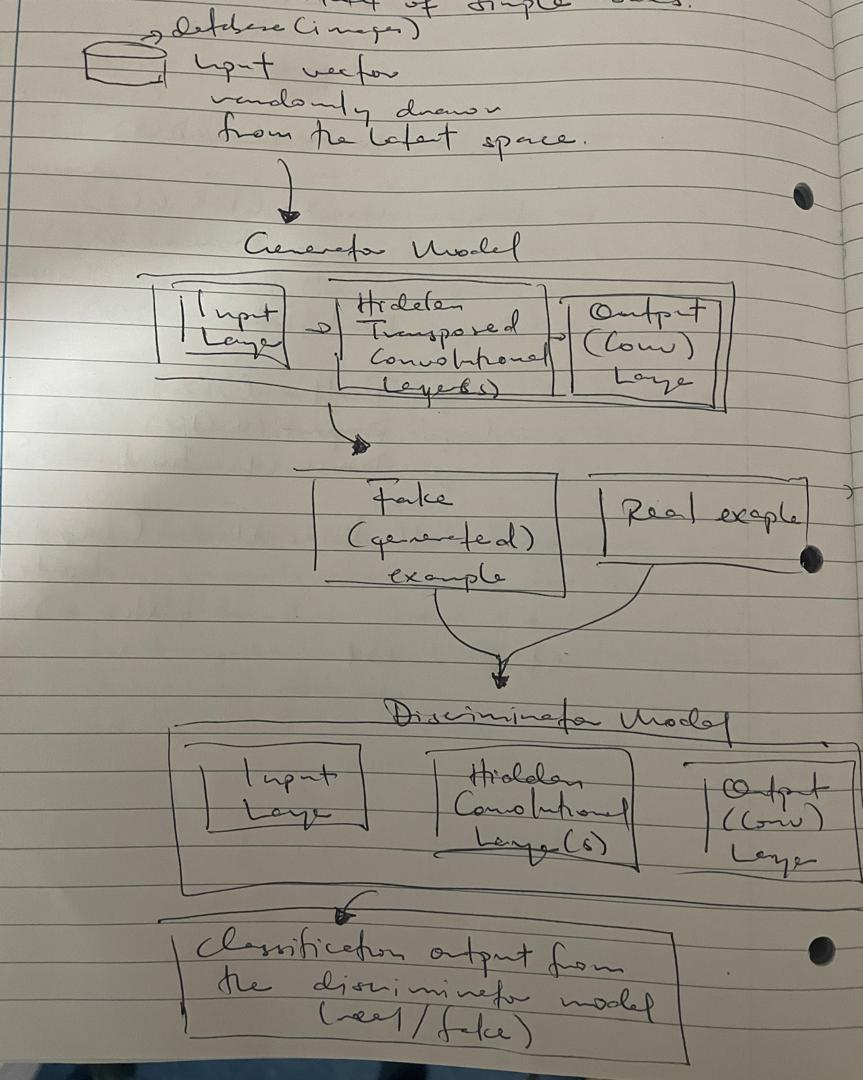

In [ ]:
#split dataset
(x_train,y_train),(x_test,y_test)=mnist.load_data()

In [ ]:
x_train.shape,y_train.shape

In [ ]:
##view one image
import matplotlib.pyplot as plt

images = x_train[:10]

images.shape

In [ ]:
len(images)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
#first part is to define the function for the generator
#the generator takes in a noisy vecotr of size N-depending on the computational resources of the engineer
#the model then tries to use this noise to generate an image through a denoising and upsampling  process

#implement
from tensorflow.keras import layers

def generator(random_noise:int=100):
    #input layer
    noise = layers.Input(shape=(random_noise,))
    #define the first dense layer
    x = layers.Dense(units=7*7*256, use_bias=False,name='Dense_1')(noise)

    x = layers.BatchNormalization(name='Batch_normalizer_1')(x)

    x = layers.LeakyReLU(name='Activation_1')(x)

    x = layers.Reshape((7,7,256))(x)
    #ensure shape
    assert x.shape==(None,7,7,256)

    x = layers.Conv2D(filters=128,kernel_size=(5,5),strides=(1,1),padding='same',use_bias=False,name='Conv_1')(x)

    #assert shape
    assert x.shape == (None,7,7,128)

    x = layers.BatchNormalization(name='Batch_normalizer_2')(x)

    x = layers.LeakyReLU(name='Activation_2')(x)

    #upsample the image to get real images
    x = layers.UpSampling2D(size=(2,2),name='Upsample_1')(x)

    x = layers.Conv2D(filters=64,kernel_size=(5,5),strides=(1,1),padding='same',use_bias=False,name='Conv_2')(x)
    #assert shape
    assert x.shape==(None,14,14,64)

    x = layers.BatchNormalization(name='Batch_normalizer_3')(x)

    x = layers.LeakyReLU(name='Activation_3')(x)

    x = layers.UpSampling2D(size=(2,2),name='Upsample_3')(x)

    x = layers.Conv2D(filters=1,kernel_size=(5,5),strides=(1,1),padding='same',use_bias=False)(x)

    #activation with tanh
    x = layers.Activation('tanh')(x)

    assert x.shape == (None,28,28,1)

    model = tf.keras.Model(inputs=noise,outputs=x)
    return model

In [ ]:
#initiate model
gen_model=generator()

In [ ]:
gen_model.summary(show_trainable=True,expand_nested=True)

In [ ]:
##define the discrimnator
#the task of the discriminator is that of a classifiier
#it classifies any image as either real(1) or fake(0)
#so given any image, we want it to be smart and attentive enough to tell whether an image is real or fake
##as this would be a CNN model, we need to give it an indepth receptive field to capture high level features from the images
import typing
def discriminator(input_shape=(28, 28, 1),activation:typing.Literal['sigmoid','softmax']='sigmoid'):
    # image input layer
    images = layers.Input(shape=input_shape,name='input_disc')

    #setup convolutional layers
    #number of filters=64, ks=5x5 and stride=2 window slides, padding=same as the input image resolution
    x = layers.Conv2D(filters=64,
                      kernel_size=(5,5),
                      strides=(2,2),
                      padding='same',
                      dilation_rate=(1,1),
                      use_bias=False,
                      name='Conv_1_disc')(images)

    x = layers.LeakyReLU(negative_slope=0.2,
                         name='Activation_disc_1')(x)

    x = layers.Conv2D(filters=128,
                      kernel_size=(5,5),
                      strides=(2,2),
                      padding='same',
                      dilation_rate=(1,1),
                      use_bias=False,
                      name='Conv_2_disc')(x)

    x = layers.LeakyReLU(negative_slope=0.2,
                         name='Activation_disc_2')(x)

    ##add more for deeper network and deeper receptive fields
    # x = layers.Conv2D(filters=256,kernel_size=(5,5),strides=(2,2),padding='same',dilation_rate=(1,1),use_bias=False)
    # x = layers.LeakyReLU(0.2)(x)

    #flatten output of convolution feature maps
    x = layers.Flatten(name='flatten_layer')(x)

    x = layers.Dropout(rate=0.01,name='Dropout')(x)

    x = layers.Dense(units=1,
                     activation=activation,
                     use_bias=True,
                     name='Dense_final_disc')(x)

    model = tf.keras.Model(inputs=images,outputs=x)

    return model

In [ ]:
#initiate the model
disc_model = discriminator()

In [ ]:
#print summary
disc_model.summary(show_trainable=True,expand_nested=True)

Great, now that you have your discriminator and generator models
its to to define the loss functions for the two models
since each model has a different task that somehow intertwine, they have different ways they are assessed by performance. like, for the generator its task is to generate realistic images from random noise. as such its loss function should measure its ability to fool the discriminator whose task it to catch any fake image and let us know that it is fake and tell us it is real if it actually is. therefore its loss function will measure how well it is able to differentiate between the 2 images.

In [ ]:
##loss for the generator
def gen_loss_fn(fake_image):
    """This loss encourages the generator to produce images that look real enough to fool the discriminator."""
    return tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(fake_image),fake_image)

##loss for the discriminator
def disc_loss_fn(fake_image,real_image):
    """The discriminator is rewarded when it correctly distinguishes real vs fake.

        It is penalized when it misclassifies either.

        This keeps the discriminator honest, while the generator tries to fool it by making fake images look real.
        """
    #Create a tensor of ones (label = real). so that the discriminator is penalized if it doesn’t classify real images as real.
    real_img_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(real_image),real_image)
    #Create a tensor of zeros (label = fake). so that the discriminator is penalized if it doesn’t classify fake images as fake.
    fake_img_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.zeros_like(fake_image),fake_image)
    #scale the loss for consistency and easy interpretation
    return (real_img_loss+fake_img_loss)/2.0

Now lets create a custom GANS model. this is best practice in GANs because, GANs contain two separate models, we cannot compile both models with a single `compile()` method and same loss function. So we need to build a single model that incorporates the 2 separate components thats the `generator()` and the `discriminator()`.

In [ ]:
##implementing the GAN which will subclass the tf.keras.models.Model class
from typing import Dict
class GAN(tf.keras.models.Model):
    def __init__(self,
                 discriminator:tf.keras.models.Model,
                 generator:tf.keras.models.Model,
                 random_noise:int,
                 activation:typing.Literal['softmax','sigmoid']='softmax'
                 ):
        super(GAN,self).__init__()
        self.discriminator=discriminator
        self.generator=generator
        self.random_noise=random_noise
        self.activation=activation

    #configure the compile method from the default keras model
    ##this will be customized to contain both losses and optimizers
    #remember the compile method allows us to specify the loss function and the optimizer
    def compile(self,
                disc_loss_fn:typing.Callable,
                gen_loss_fn:typing.Callable,
                disc_opt:tf.keras.optimizers.Optimizer,
                gen_opt:tf.keras.optimizers.Optimizer,
                **kwargs):
        """Uses the compile method from the model and modifies it to contain 2 model metrics and optimizers"""
        super(GAN,self).compile(**kwargs)
        self.disc_loss = disc_loss_fn
        self.gen_loss = gen_loss_fn
        self.disc_opt = disc_opt
        self.gen_opt = gen_opt

    #settting up the trainer for training the model with all its components
    def train_step(self,real_images:tf.Tensor)->Dict[str,tf.Tensor]:
        #batch_size of images

        batch_size = tf.shape(real_images)[0]#get the 'None' dim or 'dim 0' which represents the batch

        ##initiate the random_noise for the generator
        random_noise = tf.random.normal([batch_size,self.random_noise]) #generate batch_size x noise dimension or length for simplicity eg (10,100) implies 10 random 100 dim noises

        ##the random noises will be sent through the generator
        #lets start the training with gradient tape for flexibility and control over how losses and gradients are updated

        with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
            #step1-generator generates images with batch_size x dimension
            generated_images = self.generator(random_noise,training=True)

            #step2-discriminator makes a prediction with the generated image
            #it takes a real image and makes a predicition
            #we are trying to get the loss
            #get predictions from the discriminator
            real_image_pred = self.discriminator(real_images,
                                                 activation=self.activation,
                                                 training=True) #note that this comes in a batched form thus (batch_size,28,28)
            #pass the generated image as well for the discriminator to predict
            fake_image_pred = self.discriminator(generated_images,
                                                 activation=self.activation,
                                                 training=True)
            #after the predictions made, calculate the loss-remember we are using the BinaryCrossEntropyLoss(from_logits=True)
            gen_loss = self.gen_loss(fake_image_pred)
            disc_loss = self.disc_loss(fake_image_pred,real_image_pred)

        #calc the gradients with the loss values retrieved
        #gradients calc for the generator
        gen_grad = gen_tape.gradient(gen_loss,self.generator.trainable_variables)
        #calculate gradient fror the discriminator
        disc_grad = disc_tape.gradient(target=disc_loss,sources=self.discriminator.trainable_variables)

        #apply the gradients using the optimizer
        self.gen_opt.apply_gradients(zip(gen_grad,
                                             self.generator.trainable_variables))
        self.disc_opt.apply_gradients(zip(disc_grad,
                                              self.discriminator.trainable_variables))
        #update the metrics
        for metric in self.metrics:
            metric.update_state(real_images,generated_images)

        #construct a dictionary of metrics
        results = {m.name:m.result() for m in self.metrics}

        #update the metrics
        results.update({'disc_loss':disc_loss, 'gen_loss':gen_loss})

        return results

The next class allows us to create gridlike images of any size we want.
It also enables us to store the results of the predictions in a directory of choice
The arguments include `noise_dim` which is the dimensionality of the noise, `results_path` for the directory where i want to store the results. The `examples_to_generate` which the number of images to generate
`grid_size` which controls the size of the grids to arrange the images
`spacing` the spacing between the generated images
`gif_size` the size of the gif to be generated
`duration` the duration of each frame in the gif.

In [ ]:
!pip install opencv-python -q

In [ ]:
import cv2
import numpy as np
import os
import imageio
class ResultsCallback(tf.keras.callbacks.Callback):
    """A callback that saves generated images after each epoch."""
    def __init__(
            self,
            noise_dim: int,
            results_path: str,
            examples_to_generate: int=16,
            grid_size: tuple=(4, 4),
            spacing: int=5,
            gif_size: tuple=(416, 416),
            duration: float=0.1
        ):
        """ Initializes the ResultsCallback class.

        Args:
            noise_dim (int): The dimensionality of the noise vector that is inputted to the generator.
            results_path (str): The path to the directory where the results will be saved.
            examples_to_generate (int, optional): The number of images to generate and save. Defaults to 16.
            grid_size (tuple, optional): The size of the grid to arrange the generated images. Defaults to (4, 4).
            spacing (int, optional): The spacing between the generated images. Defaults to 5.
            gif_size (tuple, optional): The size of the gif to be generated. Defaults to (416, 416).
            duration (float, optional): The duration of each frame in the gif. Defaults to 0.1.
        """
        super(ResultsCallback, self).__init__()
        self.seed = tf.random.normal([examples_to_generate, noise_dim]) #for each image in the grid
        self.results = []
        self.results_path = results_path + '/results'
        self.grid_size = grid_size
        self.spacing = spacing
        self.gif_size = gif_size
        self.duration = duration

        # create the results directory if it doesn't exist
        os.makedirs(self.results_path, exist_ok=True)

    def save_pred(self, epoch: int, results: list) -> None:
        """ Saves the generated images as a grid and as a gif.

        Args:
            epoch (int): The current epoch.
            results (list): A list of generated images.
        """
        # construct an image from generated images with spacing between them using numpy
        w, h , c = results[0].shape
        # construct grid with self.grid_size
        grid = np.zeros((self.grid_size[0] * w + (self.grid_size[0] - 1) * self.spacing, self.grid_size[1] * h + (self.grid_size[1] - 1) * self.spacing, c), dtype=np.uint8)
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                grid[i * (w + self.spacing):i * (w + self.spacing) + w, j * (h + self.spacing):j * (h + self.spacing) + h] = results[i * self.grid_size[1] + j]

        # save the image
        cv2.imwrite(f'{self.results_path}/img_{epoch}.png', grid)

        # save image to memory resized to gif size
        self.results.append(cv2.resize(grid, self.gif_size, interpolation=cv2.INTER_AREA))

    def on_epoch_end(self, epoch: int, logs: dict=None) -> None:
        """Executes at the end of each epoch."""
        predictions = self.model.generator(self.seed, training=False)
        predictions_uint8 = (predictions * 127.5 + 127.5).numpy().astype(np.uint8)
        self.save_pred(epoch, predictions_uint8)

    def on_train_end(self, logs=None) -> None:
        """Executes at the end of training."""
        # save the results as a gif with imageio

        # Create a list of imageio image objects from the OpenCV images
        imageio_images = [imageio.core.util.Image(image) for image in self.results]

        # Write the imageio images to a GIF file
        imageio.mimsave(self.results_path + "/output.gif", imageio_images, duration=self.duration)

In [ ]:
##now lets train the model
import pathlib
x_train = (x_train.astype('float32')-127.5)/127.5

image_shape = (28,28,1)
noise_dim = 100
model_path = './models/01_gan_mnist'

#make the model_path a directory
if pathlib.Path(model_path):
    print(f'path {model_path} already exists')
else:
    print(f'{model_path} does not exist. creating.....')
    os.makedirs(model_path,exist_ok=True)


#call generator
gen_model = generator(random_noise=noise_dim)

#call the discriminator
disc_model = discriminator(input_shape=image_shape,activation='sigmoid')

#setup model optimizers
gen_opt = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.99,beta_2=0.99,weight_decay=0.01)
disc_opt = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.99,beta_2=0.99,weight_decay=0.01)

#setup the model callbacks
callbacks = ResultsCallback(noise_dim=noise_dim,results_path=model_path) #leave the rest at defualt unless you have a reason to change

#setup tensorboard for experiment tracking
try:
    import tensorboard
    import datetime
except ModuleNotFoundError:
    print('[INFO] module not found, installing..')
    !pip install tensorboard
    import tensorboard
    import datetime
#setup log directory
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#configure tensorboard as callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
#setup model
gan = GAN(discriminator=disc_model,generator=gen_model,random_noise=noise_dim,activation='sigmoid')

In [ ]:
#view model architecture
gan.summary()

Yes, this is accurate as the GAN model is just two separate models working hand in hand to produce fine images

In [ ]:
##to see a more detailed summary set 'show_trainable=True' and 'expand_nested=True'
gan.summary(show_trainable=True, expand_nested=True)

Beautiful model, this model is supposed to output an image, so the shape at the end of the model `(None,28,28,1)` is accurate where the None is the batch_size and the 28 and 28 are resolutions and the 1 is color channel being grayscale

In [ ]:
##compile the model
gan.compile(disc_loss_fn=disc_loss_fn,
            gen_loss_fn=gen_loss_fn,
            disc_opt=disc_opt,
            gen_opt=gen_opt,
            run_eagerly=False)

In [ ]:
##fit the model
r = gan.fit(x_train,epochs=50,verbose=True,callbacks=[tensorboard_callback,callbacks],batch_size=128)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs